In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import re

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Open Sans']
# rcParams['font.weight'] = 'semibold'

haec_h = (0 / 256.0, 113 / 256.0, 157 / 256.0)
haec_a = (14 / 256.0, 180 / 256.0, 142 / 256.0)
haec_e = (138 / 256.0, 200 / 256.0, 101 / 256.0)
haec_c = (178 / 256.0, 210 / 256.0, 51 / 256.0)

seed_to_plot = 11
max_time = 50
runs = [0,1,2]

name_to_read = '../output/last_output.csv'

In [3]:
FORMAT = re.compile('GeneratedI(\d+)O(\d+)Seed\d+')
MODEL_X_FORMAT = 'Input: {}\nOutput: {}'
model_order = [MODEL_X_FORMAT.format(i, o) for i, o in ((4,2), (8,2), (8,4), (10,2), (12,2), (14,4), (15,5))]

def change_model_name(old_name):
    match = FORMAT.match(old_name)
    if match:
        return MODEL_X_FORMAT.format(*match.groups())
    return old_name

def normalise_data(data):
    data = data.groupby(['Tool', 'Model', 'RunIndex', 'MetricName']).aggregate({'MetricValue': 'sum'}).reset_index()
    data = data.groupby(['Tool', 'Model', 'MetricName']).mean().reset_index()
    data.loc[:, 'Model'] = data['Model'].apply(change_model_name)
    data['ModelOrder'] = data.apply(lambda row : model_order.index(row['Model']), axis=1)
    data.sort_values('ModelOrder')
    return data

#    # get the baselines
#    objective = data[np.where(0 == data['numClusters'])][0]['objective']
#    generationTime = data[np.where(0 == data['numClusters'])][0]['generationTime']
#    solvingTime = data[np.where(0 == data['numClusters'])][0]['solvingTime']

#    # remove the unclustered measurement
#    data = data[np.where(data['numClusters'] != 0)]

#    data['objective'] = objective / data['objective']
#    data['objective'][np.isinf(data['objective'])] = 0

#    return objective, generationTime, solvingTime, data

In [4]:
def read_measurements(file_name=None):
    if file_name is None:
        file_name = name_to_read
    data = pd.read_csv(file_name, delimiter=';')
                       #, skip_header=0,
                       #  names=('Tool', 'Model', 'RunIndex', 'PhaseName', 'MetricName', 'MetricValue'))
                         #dtype=(string,str,int,str,str,float))

    # Normalize data
    data = normalise_data(data)

    # Split time and memory data
    time_data = data[data['MetricName'] == 'Time'].copy()
    nodes_data = data[data['MetricName'] == 'DecisionNodes'].copy()
    time_data.loc[:, 'MetricValue'] = time_data['MetricValue'] / 10e6

#    data['value'] = data['MetricValue'] / 10e6
    return (time_data, nodes_data)

In [5]:
my_dpi = 300
# plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# f, axes = plt.subplots(2, 3, sharey=False,figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# plt.subplots_adjust(left=.04,right=.96,bottom=.15, top=.96, wspace=.4, hspace=.2)
# plt.tight_layout()

Original CSV header was: 

run|seed|numClusters|isValid|objective|clusteringTime|generationTime|solvingTime
-|-|-|-|-|-|-|-
0|11|0|true|1104501.5899999999|0|2451|20838

And new header is:

Tool|Model|RunIndex|PhaseName|MetricName|MetricValue
-|-|-|-|-|-
EMFSolutionATLGraph|Test.ttmodel|0|Initialization|Time|270028458


In [6]:
good_colors = ['#000000','#e69f00','#56b4e9','#009e73','#f0e442','#0072b2','#d55e00','#cc79a7']
good_shapes = ['o', 's', 'v', '^', 'x']
good_dashes = ['-', '--', ':', '-.']

info = {
#    'EMFSolutionATL':               (good_colors[0], good_shapes[0], good_dashes[0], 'ATL'),
    'EMFSolutionATLGraph':          (good_colors[1], good_shapes[1], good_dashes[0], 'ATL (Graph)'),
    'RelationalRAGSolutionBDT':     (good_colors[2], good_shapes[2], good_dashes[0], 'RelRAG BDT'),
    'RelationalRAGSolutionOBDT':    (good_colors[3], good_shapes[3], good_dashes[0], 'RelRAG OBDT'),
#    'RelationalRAGSolutionOBDT-H':  (good_colors[3], good_shapes[4], good_dashes[0], 'RelRAG OBDT-H'),
    'RelationalRAGSolutionOBDD':    (good_colors[4], good_shapes[3], good_dashes[0], 'RelRAG OBDD'),
#    'RelationalRAGSolutionOBDD-H':  (good_colors[4], good_shapes[4], good_dashes[0], 'RelRAG OBDD-H'),
    'RelationalRAGSolutionROBDD':   (good_colors[5], good_shapes[3], good_dashes[0], 'RelRAG ROBDD'),
    'RelationalRAGSolutionROBDD-H': (good_colors[5], good_shapes[4], good_dashes[0], 'RelRAG ROBDD-H')
}

In [7]:
def reformat(data, tools):
    ids = data['ModelOrder'].unique()
    new_data = pd.DataFrame(data=None, index=ids, columns=['Model'] + sorted(tools))
    new_data['Model'] = data['Model'].unique()
    #new_data['ModelOrder'] = time_data['ModelOrder'].unique()

    for tool in tools:
        data_for_tool = data[data['Tool'] == tool]
        for model_id in ids:
            try:
                value = data_for_tool[data_for_tool['ModelOrder'] == model_id]['MetricValue'].item()
                # at[row, column] = value
                new_data.at[model_id, tool] = value
            except:
                pass
    new_data.sort_index(inplace=True)
    return new_data

In [8]:
time_data, nodes_data = read_measurements()
time_data = reformat(time_data, list(info))
nodes_data = reformat(nodes_data, [tool for tool in info if 'ATL' not in tool])
values = nodes_data.drop('Model', axis=1)
nodes_data.loc[:, nodes_data.columns != 'Model'] = values.div(values.max(axis=1), axis=0)

In [9]:
def draw_bar(data, axis_title, colors, logY, output_name):
    fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
    ax1 = fig.add_subplot(111)
    if logY:
        ax1.set_yscale('log')
    #else:
    #    ax1.set_ylim(0, 1.19 * data['MetricValue'].max())
    data.plot(x="Model", y=sorted(data.columns[1:]), kind="bar", ax=ax1, color=colors,
                  label=[info[key][3] for key in sorted(data.columns[1:])])
    ax1.set_xlabel('Model instance',weight='semibold',name='Open Sans')
    ax1.set_ylabel(axis_title, weight='semibold',name='Open Sans')
    ax1.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.5, -1.0))
    plt.tight_layout()
    fig.savefig(output_name + '.pdf', format="pdf", dpi=fig.dpi)
    fig.savefig(output_name + '.png', format="png", dpi=fig.dpi)

In [10]:
nodes_data

,Model,RelationalRAGSolutionBDT,RelationalRAGSolutionOBDD,RelationalRAGSolutionOBDT,RelationalRAGSolutionROBDD,RelationalRAGSolutionROBDD-H
0,Input: 4\nOutput: 2,0.933333,1,1,0.733333,0.733333
1,Input: 8\nOutput: 2,0.858824,1,1,0.505882,0.505882
2,Input: 8\nOutput: 4,0.976471,1,1,0.862745,0.858824
3,Input: 10\nOutput: 2,0.876833,1,1,0.4174,0.407625
4,Input: 12\nOutput: 2,0.867155,1,1,0.310134,0.308425
5,Input: 14\nOutput: 4,0.969175,1,1,0.506623,0.505829
6,Input: 15\nOutput: 5,0.98471,1,1,0.529008,0.529283


In [11]:
for tool in ('RelationalRAGSolutionROBDD', 'RelationalRAGSolutionROBDD-H'):
    for f in (min, max):
        print(f([x for x in nodes_data[tool].values.tolist()]))

0.31013431013431014
0.8627450980392157
0.30842490842490844
0.8588235294117647


In [12]:
for n,h in zip(nodes_data['RelationalRAGSolutionROBDD'].values.tolist(), nodes_data['RelationalRAGSolutionROBDD-H'].values.tolist()):
    print((1-h/n)*100)

0.0
0.0
0.454545454545463
2.3419203747072626
0.5511811023622082
0.15662650602410455
-0.05192107995846129


In [13]:
time_data

,Model,EMFSolutionATLGraph,RelationalRAGSolutionBDT,RelationalRAGSolutionOBDD,RelationalRAGSolutionOBDT,RelationalRAGSolutionROBDD,RelationalRAGSolutionROBDD-H
0,Input: 4\nOutput: 2,52.5044,2.12441,2.1038,2.09396,2.14307,2.39819
1,Input: 8\nOutput: 2,3174.27,7.43895,7.41669,6.98542,7.56668,8.30951
2,Input: 8\nOutput: 4,4118.5,8.00771,7.25884,6.93422,7.63646,8.6578
3,Input: 10\nOutput: 2,85488.2,11.2541,10.9558,11.2205,12.7106,13.3569
4,Input: 12\nOutput: 2,NaN,26.0685,26.7032,25.7003,30.7294,31.3944
5,Input: 14\nOutput: 4,NaN,75.3798,66.0022,63.6212,118.908,115.051
6,Input: 15\nOutput: 5,NaN,140.745,128.658,121.339,318.204,304.072


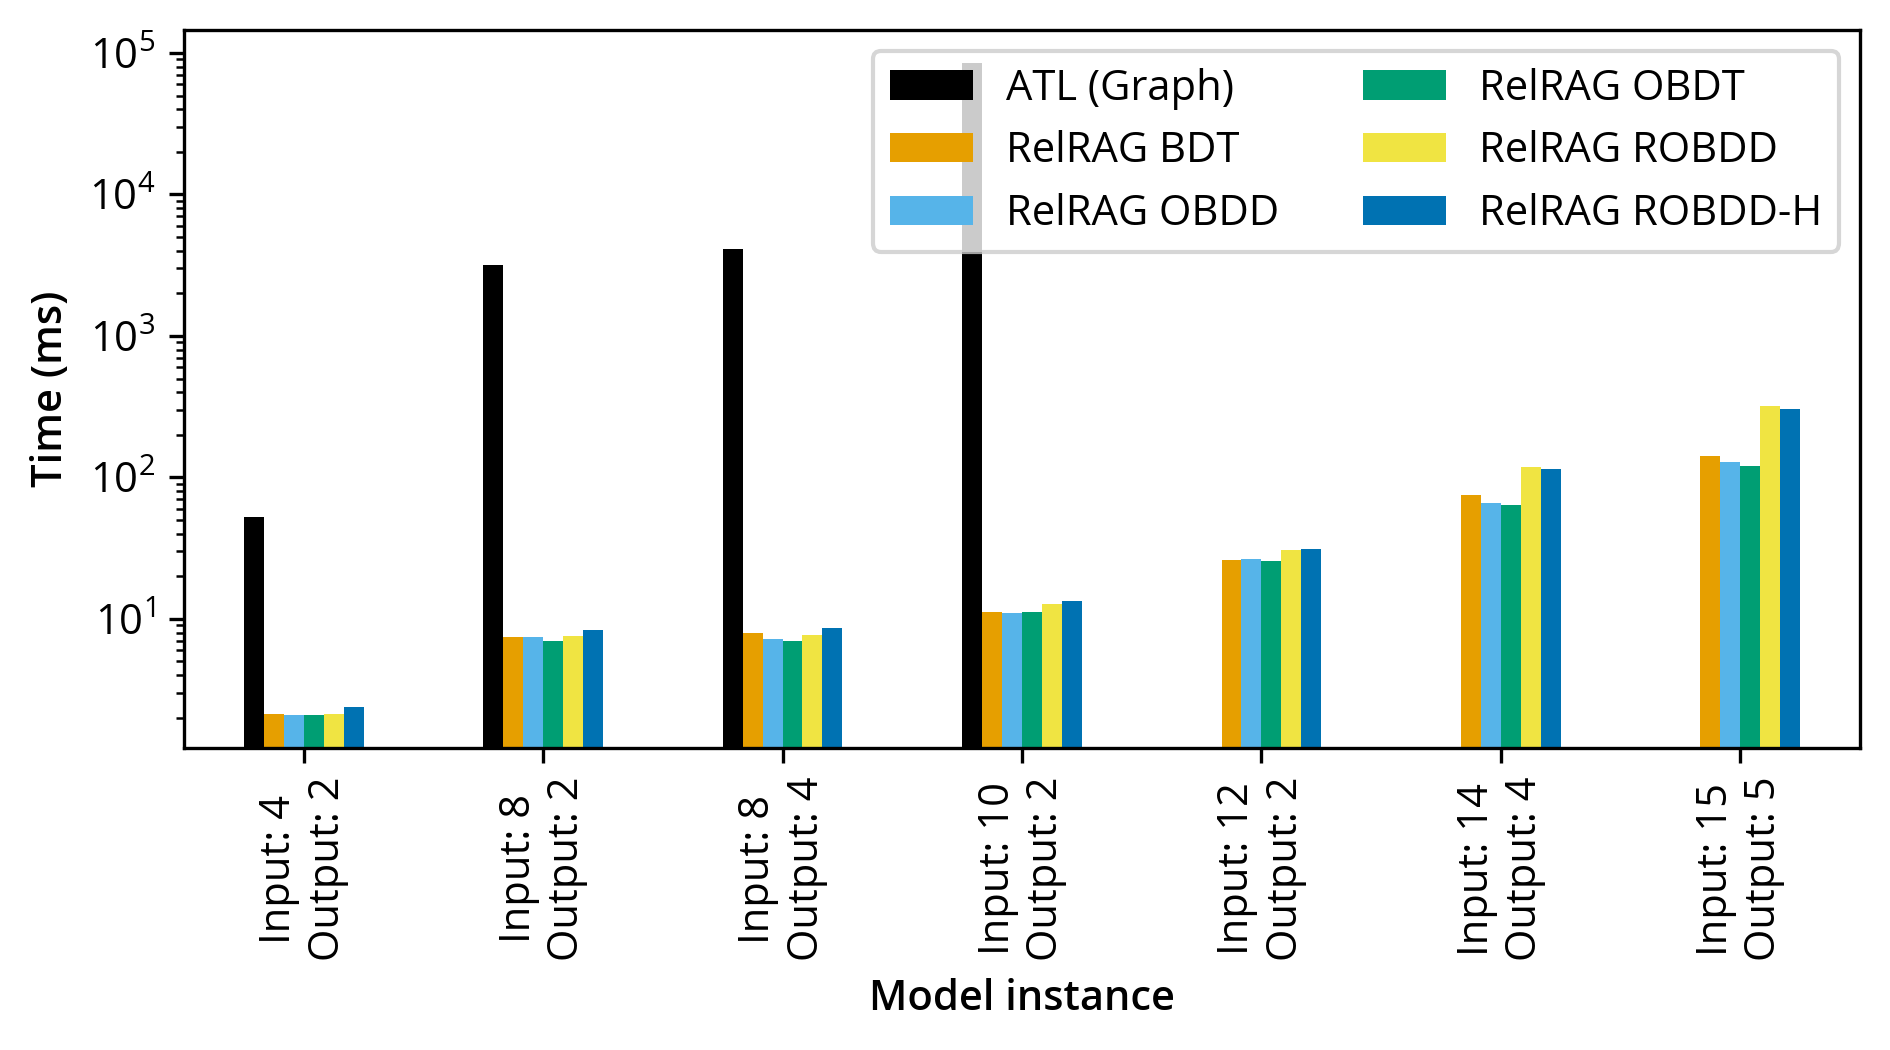

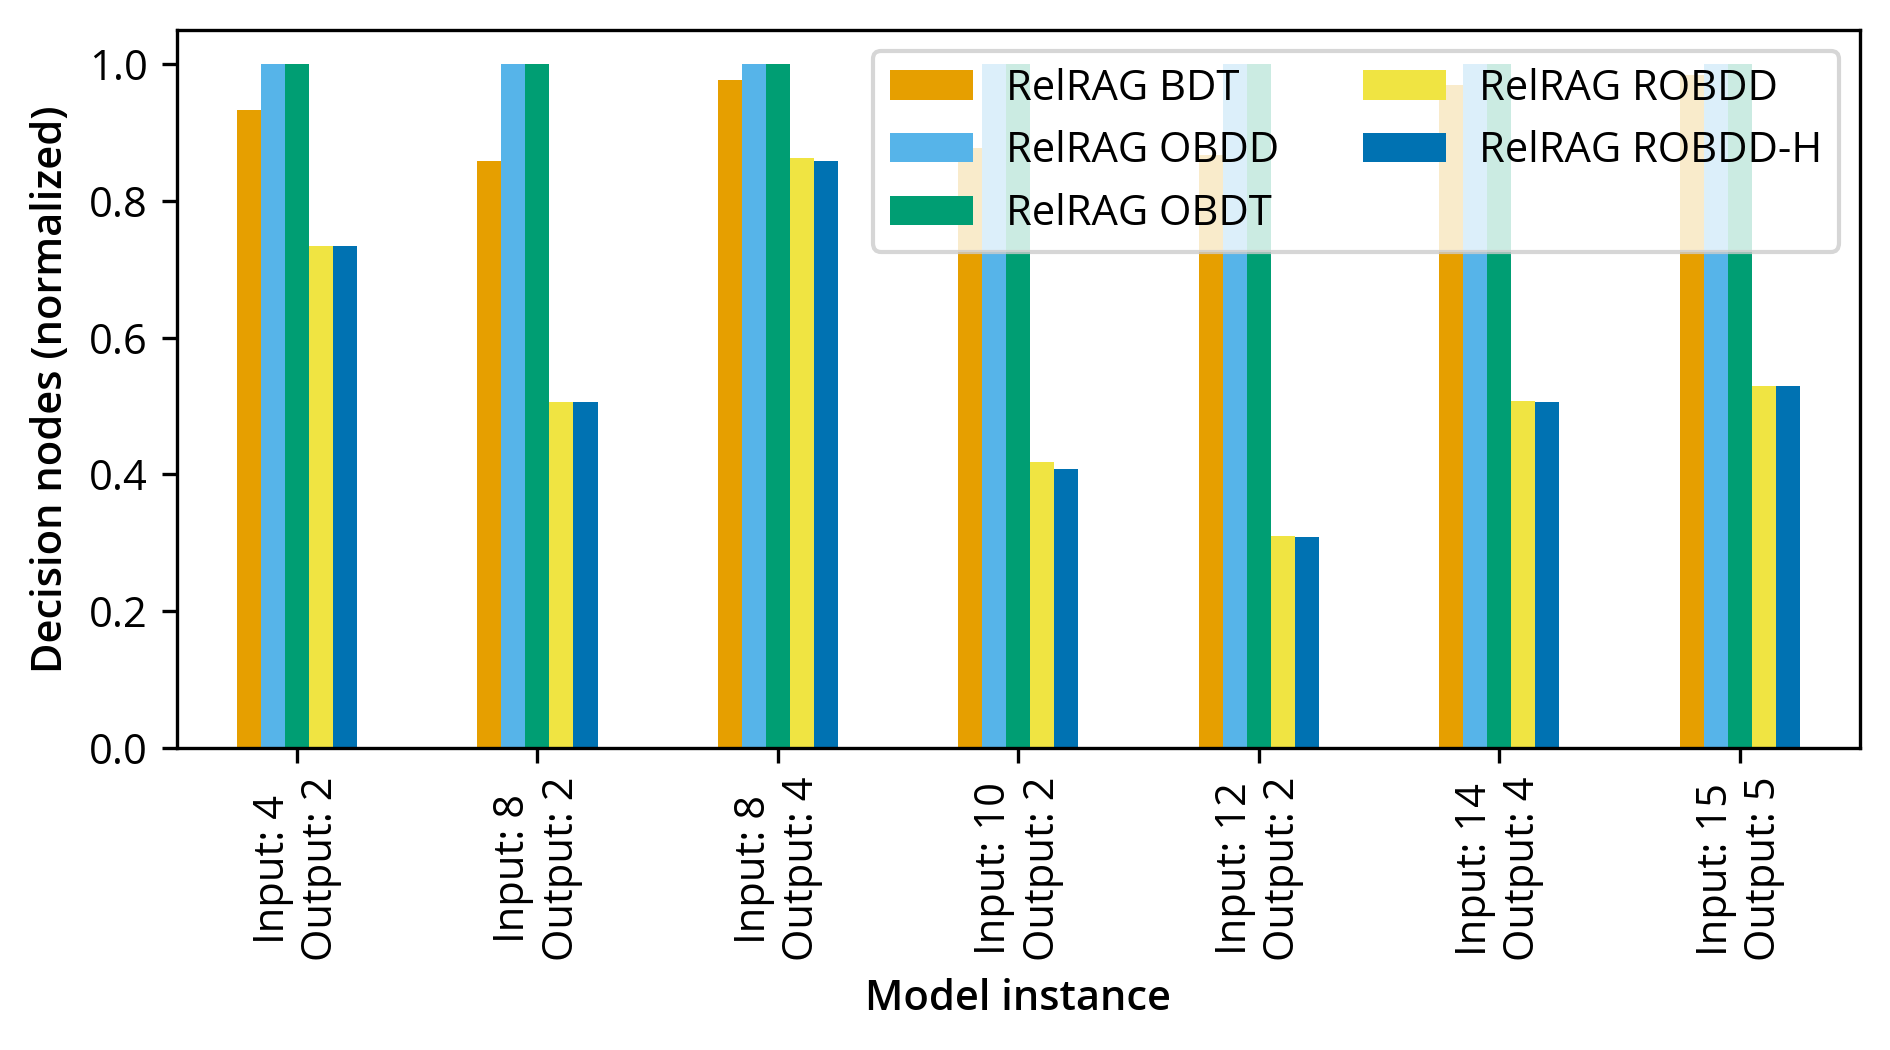

In [14]:
draw_bar(time_data, 'Time (ms)', good_colors, True, 'run_time')
# assumption ATL is at first place, thus leave out first color
draw_bar(nodes_data, 'Decision nodes (normalized)', good_colors[1:], False, 'nodes')